In [1]:
import os
import datetime
import time
from IPython.display import clear_output

import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.loader.dataloader import DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from ClusterDataset import ClusterDataset
from training import *
from data_statistics import *

from GNN_TrackLinkingNet import GNN_TrackLinkingNet, FocalLoss, EarlyStopping, weight_init

from IPython.display import display

2025-05-16 18:03:46.215607: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 18:03:46.236727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747411426.261300    1276 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747411426.268629    1276 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-16 18:03:46.295097: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load the dataset
hist_folder = "/eos/user/c/czeh/histo_new/"
data_folder_training = "/eos/user/c/czeh/graph_data"
data_folder_test = "/eos/user/c/czeh/graph_data_test"

model_folder = "/eos/user/c/czeh/model"
dataset_training = ClusterDataset(data_folder_training, hist_folder)
dataset_test = ClusterDataset(data_folder_test, hist_folder, test=True)

In [4]:
print_dataset_statistics(dataset_training)

Number of events in training dataset: 299


/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_dir, f'data_{

Number of nodes: 8710
Mean Number of nodes: 29.130434782608695
Number of edges: 53836
Mean Number of edges: 180.05351170568562
Number of positive edges: 47377
Mean Number of positive edges: 158.45150756835938
Number of negative edges: 6459
Mean Number of negative edges: 21.602006912231445


In [5]:
print_dataset_statistics(dataset_test)

Number of events in training dataset: 100
Number of nodes: 2891
Mean Number of nodes: 28.91
Number of edges: 17805
Mean Number of edges: 178.05
Number of positive edges: 15627
Mean Number of positive edges: 156.27000427246094
Number of negative edges: 2178
Mean Number of negative edges: 21.780000686645508


In [6]:
train_dl = DataLoader(dataset_training, shuffle=True)
test_dl = DataLoader(dataset_test, shuffle=True)

In [7]:
epochs = 200
start_epoch = 0

model = GNN_TrackLinkingNet(input_dim = dataset_training.model_feature_keys.shape[0], 
                                edge_feature_dim=dataset_training.get(0).edges_features.shape[1],
                                edge_hidden_dim=16, hidden_dim=16, weighted_aggr=True,
                               dropout=0.3)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-6)
loss_obj = FocalLoss(alpha=0.45, gamma=2)
early_stopping = EarlyStopping(patience=20, delta=-2)

model.apply(weight_init)

# weights = torch.load(model_folder + "/model_epoch_100_loss_26.8352_2025-05-13.pt", weights_only=True)
# model.load_state_dict(weights["model_state_dict"])
# optimizer.load_state_dict(weights["optimizer_state_dict"])
# start_epoch = weights["epoch"]

GNN_TrackLinkingNet(
  (inputnetwork): Sequential(
    (0): Linear(in_features=17, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (edge_inputnetwork): Sequential(
    (0): Linear(in_features=7, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (attention_direct): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=1, bias=True)
    (4): Sigmoid()
  )
  (attention_reverse): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)


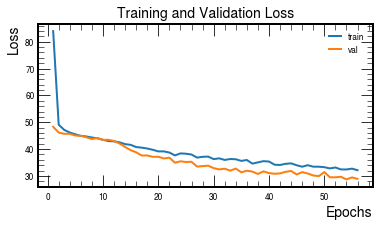

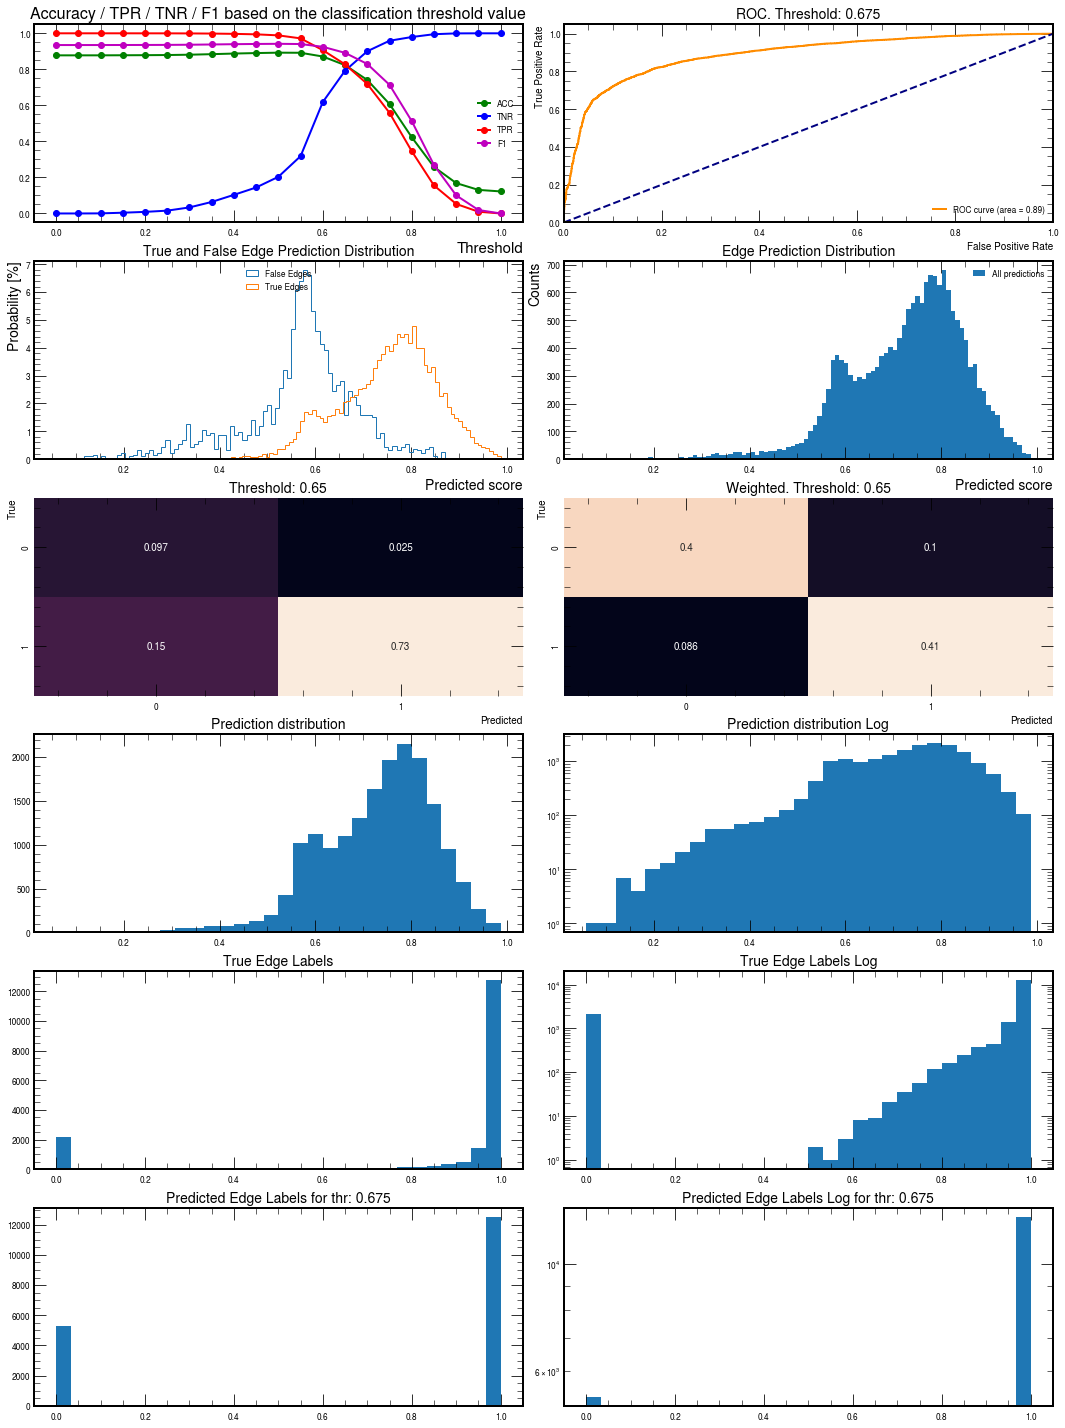

Epoch: 1


Training epoch 1: 100%|██████████| 299/299 [00:06<00:00, 48.64it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 81.34it/s]


Epoch: 2


Training epoch 2: 100%|██████████| 299/299 [00:05<00:00, 56.25it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 112.62it/s]


Epoch: 3


Training epoch 3: 100%|██████████| 299/299 [00:04<00:00, 61.93it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.03it/s]


Epoch: 4


Training epoch 4: 100%|██████████| 299/299 [00:04<00:00, 61.02it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 106.37it/s]


Epoch: 5


Training epoch 5: 100%|██████████| 299/299 [00:04<00:00, 62.25it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 121.69it/s]


Epoch: 6


Training epoch 6: 100%|██████████| 299/299 [00:05<00:00, 56.20it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 113.82it/s]


Epoch: 7


Training epoch 7: 100%|██████████| 299/299 [00:04<00:00, 61.44it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 116.33it/s]


Epoch: 8


Training epoch 8: 100%|██████████| 299/299 [00:04<00:00, 61.96it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.57it/s]


Epoch: 9


Training epoch 9: 100%|██████████| 299/299 [00:05<00:00, 59.06it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 103.74it/s]


Epoch: 10


Training epoch 10: 100%|██████████| 299/299 [00:04<00:00, 60.24it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.86it/s]


Epoch: 11


Training epoch 11: 100%|██████████| 299/299 [00:04<00:00, 61.09it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.71it/s]


Epoch: 12


Training epoch 12: 100%|██████████| 299/299 [00:05<00:00, 59.16it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.44it/s]


Epoch: 13


Training epoch 13: 100%|██████████| 299/299 [00:04<00:00, 62.09it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.65it/s]


Epoch: 14


Training epoch 14: 100%|██████████| 299/299 [00:04<00:00, 61.12it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 104.82it/s]


Epoch: 15


Training epoch 15: 100%|██████████| 299/299 [00:04<00:00, 60.10it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 116.16it/s]


Epoch: 16


Training epoch 16: 100%|██████████| 299/299 [00:04<00:00, 62.50it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.23it/s]


Epoch: 17


Training epoch 17: 100%|██████████| 299/299 [00:04<00:00, 62.05it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.96it/s]


Epoch: 18


Training epoch 18: 100%|██████████| 299/299 [00:05<00:00, 56.23it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 86.49it/s]


Epoch: 19


Training epoch 19: 100%|██████████| 299/299 [00:04<00:00, 60.34it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 102.23it/s]


Epoch: 20


Training epoch 20: 100%|██████████| 299/299 [00:04<00:00, 62.34it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 114.04it/s]


Epoch: 20
Scores for Classification with Threshold: 0.675.
F1 score: 0.845
Balanced Accuracy: 0.751
Accuracy: 0.756
Precision: 95.4938
Recall: 75.8047
Negative predictive value: 29.9815
True negative rate: 74.3343
Precision Weighted: [0.75443609 0.74706183]
Recall Weighted: [0.74334252 0.75804697]
F1 score Weighted: [0.74884822 0.75251431]
Positive Likelihood Ratio: 2.9535354215268677
Negative Likelihood Ratio: 0.3254933288242626
Epoch: 21


Training epoch 21:   0%|          | 0/299 [00:00<?, ?it/s]/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.71it/s]


Epoch: 22


Training epoch 22: 100%|██████████| 299/299 [00:04<00:00, 60.62it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.65it/s]


Epoch: 23


Training epoch 23: 100%|██████████| 299/299 [00:04<00:00, 60.85it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 102.41it/s]


Epoch: 24


Training epoch 24: 100%|██████████| 299/299 [00:04<00:00, 61.66it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 101.24it/s]


Epoch: 25


Training epoch 25: 100%|██████████| 299/299 [00:04<00:00, 62.46it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 112.57it/s]


Epoch: 26


Training epoch 26: 100%|██████████| 299/299 [00:04<00:00, 61.51it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.28it/s]


Epoch: 27


Training epoch 27: 100%|██████████| 299/299 [00:04<00:00, 60.79it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.51it/s]


Epoch: 28


Training epoch 28: 100%|██████████| 299/299 [00:04<00:00, 62.75it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 104.44it/s]


Epoch: 29


Training epoch 29: 100%|██████████| 299/299 [00:05<00:00, 59.69it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 112.32it/s]


Epoch: 30


Training epoch 30: 100%|██████████| 299/299 [00:04<00:00, 62.36it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 114.44it/s]


Epoch: 31


Training epoch 31: 100%|██████████| 299/299 [00:04<00:00, 61.17it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.18it/s]


Epoch: 32


Training epoch 32: 100%|██████████| 299/299 [00:04<00:00, 63.43it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 115.41it/s]


Epoch: 33


Training epoch 33: 100%|██████████| 299/299 [00:04<00:00, 62.18it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.96it/s]


Epoch: 34


Training epoch 34: 100%|██████████| 299/299 [00:04<00:00, 64.87it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.73it/s]


Epoch: 35


Training epoch 35: 100%|██████████| 299/299 [00:04<00:00, 61.08it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.07it/s]


Epoch: 36


Training epoch 36: 100%|██████████| 299/299 [00:04<00:00, 61.66it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 102.06it/s]


Epoch: 37


Training epoch 37: 100%|██████████| 299/299 [00:04<00:00, 60.55it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.63it/s]


Epoch: 38


Training epoch 38: 100%|██████████| 299/299 [00:04<00:00, 60.39it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 102.92it/s]


Epoch: 39


Training epoch 39: 100%|██████████| 299/299 [00:04<00:00, 61.66it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.95it/s]


Epoch: 40


Training epoch 40: 100%|██████████| 299/299 [00:04<00:00, 62.07it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.90it/s]


Epoch: 40
Scores for Classification with Threshold: 0.675.
F1 score: 0.866
Balanced Accuracy: 0.816
Accuracy: 0.788
Precision: 97.4168
Recall: 77.9484
Negative predictive value: 34.9934
True negative rate: 85.1699
Precision Weighted: [0.79433615 0.84015572]
Recall Weighted: [0.85169881 0.77948423]
F1 score Weighted: [0.82201797 0.8086836 ]
Positive Likelihood Ratio: 5.25608868194902
Negative Likelihood Ratio: 0.2589128602320574
Epoch: 41


Training epoch 41:   0%|          | 0/299 [00:00<?, ?it/s]/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 116.57it/s]


Epoch: 42


Training epoch 42: 100%|██████████| 299/299 [00:04<00:00, 61.38it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 105.70it/s]


Epoch: 43


Training epoch 43: 100%|██████████| 299/299 [00:04<00:00, 62.42it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 112.84it/s]


Epoch: 44


Training epoch 44: 100%|██████████| 299/299 [00:04<00:00, 61.61it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.76it/s]


Epoch: 45


Training epoch 45: 100%|██████████| 299/299 [00:04<00:00, 61.03it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 114.16it/s]


Epoch: 46


Training epoch 46: 100%|██████████| 299/299 [00:04<00:00, 60.64it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.72it/s]


Epoch: 47


Training epoch 47: 100%|██████████| 299/299 [00:04<00:00, 61.76it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 103.89it/s]


Epoch: 48


Training epoch 48: 100%|██████████| 299/299 [00:04<00:00, 61.11it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 114.67it/s]


Epoch: 49


Training epoch 49: 100%|██████████| 299/299 [00:04<00:00, 61.83it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 112.10it/s]


Epoch: 50


Training epoch 50: 100%|██████████| 299/299 [00:05<00:00, 55.60it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 85.07it/s]


Epoch: 51


Training epoch 51: 100%|██████████| 299/299 [00:04<00:00, 60.64it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.66it/s]


Epoch: 52


Training epoch 52: 100%|██████████| 299/299 [00:04<00:00, 59.93it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 101.73it/s]


Epoch: 53


Training epoch 53: 100%|██████████| 299/299 [00:04<00:00, 63.37it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.97it/s]


Epoch: 54


Training epoch 54: 100%|██████████| 299/299 [00:04<00:00, 63.20it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 112.06it/s]


Epoch: 55


Training epoch 55: 100%|██████████| 299/299 [00:05<00:00, 56.15it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 102.58it/s]


Epoch: 56


Training epoch 56: 100%|██████████| 299/299 [00:04<00:00, 62.71it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.62it/s]


Epoch: 57


Training epoch 57:  99%|█████████▉| 297/299 [00:04<00:00, 58.00it/s]

In [ ]:
# decision_th = 0.5
os.makedirs(model_folder, exist_ok=True)

train_loss_hist = []
val_loss_hist = []
edge_features = True
date = f"{datetime.now():%Y-%m-%d}"

fig_loss, ax_loss = plt.subplots(1, 1)
fig_loss.set_figwidth(6)
fig_loss.set_figheight(3)

fig_analysis, ax_analysis = plt.subplots(6, 2)
fig_analysis.set_figwidth(15)
fig_analysis.set_figheight(20)
fig_analysis.tight_layout(pad=2.0)

display_loss = display(1, display_id=True)
display_analysis = display(2, display_id=True)

for epoch in range(start_epoch, epochs):
    print(f'Epoch: {epoch+1}')
    
    loss = train(model, optimizer, train_dl, epoch+1, device=device, edge_features=edge_features, loss_obj=loss_obj)
    train_loss_hist.append(loss)
    
    val_loss, pred, y = test(model, test_dl, epoch+1, loss_obj=loss_obj, edge_features=edge_features, device=device)
    val_loss_hist.append(val_loss)
    
    ax_loss.clear()
    plot_loss(train_loss_hist, val_loss_hist, ax=ax_loss)
    display_loss.update(fig_loss)
    time.sleep(1)
    
    early_stopping(model, val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping after {epoch+1} epochs")
        early_stopping.load_best_model(model)
        
        for axes in ax_analysis:
            for ax in axes:
                ax.clear()
                
        plot_validation_results(pred, y, save=True, ax=ax_analysis, output_folder=model_folder, file_suffix=f"epoch_{epoch+1}_date_{date}")
        display_analysis.update(fig_analysis)
        time.sleep(1)
        break
      
    if ((epoch+1)%60==0 or epoch+1==epochs):
        print(f'Epoch: {epoch+1}')
        
        for axes in ax_analysis:
            for ax in axes:
                ax.clear()
            
        plot_validation_results(pred, y, save=True, ax=ax_analysis, output_folder=model_folder, file_suffix=f"epoch_{epoch+1}_date_{date}")
        display_analysis.update(fig_analysis)
        time.sleep(1)
        
        save_model(model, epoch, optimizer, loss, val_loss, output_folder=model_folder, filename=f"model_epoch_{epoch+1}_date_{date}_loss_{loss:.4f}.pt")
    elif ((epoch+1)%20==0):
        print(f'Epoch: {epoch+1}')
        
        for axes in ax_analysis:
            for ax in axes:
                ax.clear()
        plot_validation_results(pred, y, save=False, ax=ax_analysis) 
        display_analysis.update(fig_analysis)
        time.sleep(1)

    scheduler.step() 